In [3]:
%reload_ext autoreload
%autoreload

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from IPython.core.debugger import set_trace

import topocalib
from topocalib.layout import generate_layout, show_layout
from topocalib.model_cv import generate_projections, get_pixel_coordinates, get_x_camera_pre, get_pixel_coordinates_xc
from topocalib.model import get_rotation, get_angles
from topocalib.optimizer import optimize
from topocalib.visualise import show_correlation_matrix, show_residuals, wrap

In [6]:
%matplotlib widget
%autoreload

Ts1, Rs1, X_ws1 = generate_layout(slope=np.pi/5, step=1.1, nplains=1, distance=4, plainsize=(6, 6), planetransl=[-1, -1, 0])
_, _, X_ws2 = generate_layout(nplains=1, plainsize=(6, 6), planetransl=[-1, -1, - 3.83 * 2])

"""
Ts1[:, 2] += np.random.normal(scale=0.5, size=(len(Ts1), 1))
for i in range(len(X_ws1)):
    for j in range(len(X_ws1[i])):
        X_ws1[i][j, 2] += np.random.normal(scale=0.1)
        X_ws2[i][j, 2] += np.random.normal(scale=0.1)
"""
ax = show_layout(Ts1, Rs1, X_ws1)

Rs2 = []
Ts2 = Ts1.copy()
R12 = [np.pi + np.pi / 5.5, 0, 0]

for R in Rs1:    
    R_add = get_rotation(R12)
    R_mat = get_rotation(np.matrix(R).A1) * R_add
    R_new = get_angles(R_mat)
    Rs2.append(np.matrix(R_new))


for i in range(len(X_ws2)):
    for j in range(len(X_ws2[i])):
        # X_ws2[i][j] = (get_rotation([0.0, 0.005, 0.05]) * np.matrix(X_ws2[i][j]).T).A1
        pass

X_cs1 = generate_projections(X_ws1, Ts1, Rs1)
X_cs2 = generate_projections(X_ws2, Ts2, Rs2)

show_layout(Ts2, Rs2, X_ws2, ax=ax)

FigureCanvasNbAgg()

In [47]:
t = get_rotation([1, 1, 1]) * np.matrix(X_ws2[0][0]).T
X2_w_rel = get_rotation([1, 1, 1]).T * np.matrix(t) + np.matrix([0, 0, 0]).T
print(X2_w_rel, X_ws2[0][0])

[[-0.1790911 ]
 [-5.57708076]
 [-6.2408684 ]] [-0.1790911  -5.57708076 -6.2408684 ]


In [48]:
t = get_rotation([1, 1, 1]) * np.matrix([1, 2, 3]).T
s = get_rotation([1, 1, 1]).T * t
print(t, s)

print(Ts2, Rs2)

[[ 1.90704211]
 [-1.13451704]
 [ 3.01265024]] [[1.]
 [2.]
 [3.]]
[[-1.12693023  0.          3.43943601]
 [-0.51117118  1.00432851  4.23287299]
 [ 0.6631997   0.91111904  3.39688285]
 [ 1.1128208  -0.17776839  3.47045852]
 [ 0.3463427  -1.07238914  4.14004672]
 [-0.79862139 -0.79509472  3.79277223]] [matrix([[-3.14159265, -0.28559933, -1.57079633]]), matrix([[-2.88564966, -0.12814321, -0.45428531]]), matrix([[-2.90851134,  0.16656911,  0.60965865]]), matrix([[3.09530742, 0.28192503, 1.73577287]]), matrix([[2.86912597, 0.08669423, 2.84109524]]), matrix([[ 2.93731694, -0.20100617, -2.37465258]])]


In [8]:
%autoreload


def ls_func_dual(params, Xs1_worlds, Xs1_distorteds, Xs2_worlds, Xs2_distorteds):
    """
    Function used for least-square optimisation
    """
    
    ks1 = params[0:3]
    C1 = params[3]
    center1 = params[4:6]
    
    ks2 = params[6:9]
    C2 = params[9]
    center2 = params[10:12]
    
    Rw12 = params[12:15]
    Tw12 = params[15:18]
    
    s = []
    i = 18
    #i = 6
    
    for Xs1_world, Xs1_distorted, Xs2_world, Xs2_distorted in zip(Xs1_worlds, Xs1_distorteds, Xs2_worlds, Xs2_distorteds):
        T11 = params[i:i+3]
        Rcw11 = params[i+3:i+6]
        
        T22 = params[i+6:i+9]
        Rcw22 = params[i+9:i+12]
        
        rotation1 = get_rotation(Rcw11)
        translation1 = np.matrix(T11).T
        
        rotation2 = get_rotation(Rcw22)
        translation2 = np.matrix(T22).T
        
        for X1_w, X1_d, X2_w, X2_d in zip(Xs1_world, Xs1_distorted, Xs2_world, Xs2_distorted):
            #set_trace()
            X2_w_rel = get_rotation(Rw12).T * np.matrix(X2_w).T - np.matrix(Tw12).T
            X2_w_rel = X2_w_rel.A1
            #Rall = get_angles(get_rotation(Rcw22) * get_rotation(Rw12))
            
            X1_c = get_x_camera_pre(translation1, rotation1, X1_w)
            X1_pixel = get_pixel_coordinates_xc(X1_c, ks1, C1, center1)
            
            X2_c = get_x_camera_pre(translation2, rotation2, X2_w_rel)
            X2_pixel = get_pixel_coordinates_xc(X2_c, ks2, C2, center2)
            
            #set_trace()
            s.append(X1_pixel[0, 0] - X1_d[0])
            s.append(X1_pixel[1, 0] - X1_d[1])
            #s.append(0)
            #s.append(0)
            #s.append(X2_pixel[0, 0] - X2_d[0])
            #s.append(X2_pixel[1, 0] - X2_d[1])
            
        i += 12
    return np.array(s)


x0 = [0.0, 0.0, 0.0] + [800] + [1400, 1400]
x0 += [0.0, 0.0, 0.0] + [800] + [1400, 1400]
x0 += [0.0, 0.0, 0.0] + [0.0, 0.0, 0.0]
for _ in range(len(Ts1)):
    x0 += [ 1.11, -0.17, 3.83 ] + [ -0.23, 0.17, -0.6 ]
    x0 += [ 1.11, -0.17, 3.83 ] + [ -2.9, 0.17, 0.6 ]

res = least_squares(ls_func_dual, np.array(x0), args=(X_ws1, X_cs1, X_ws2, X_cs2), jac_sparsity=None, tr_solver='lsmr', x_scale='jac', max_nfev=100)
print(res.x)

[-5.76996288e-11  1.50952249e-10 -1.30516932e-10  8.00000000e+02
  1.40000000e+03  1.40000000e+03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.00000000e+02  1.40000000e+03  1.40000000e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.12693023e+00 -7.16564041e-10
  5.28004068e+00  1.29422257e-10 -2.85599332e-01  1.57079633e+00
  1.11000000e+00 -1.70000000e-01  3.83000000e+00 -2.90000000e+00
  1.70000000e-01  6.00000000e-01 -5.11171180e-01  1.00432851e+00
  3.94794379e+00 -2.55942994e-01 -1.28143207e-01  4.54285315e-01
  1.11000000e+00 -1.70000000e-01  3.83000000e+00 -2.90000000e+00
  1.70000000e-01  6.00000000e-01  6.63199698e-01  9.11119036e-01
  4.24085736e+00 -2.33081317e-01  1.66569107e-01 -6.09658646e-01
  1.11000000e+00 -1.70000000e-01  3.83000000e+00 -2.90000000e+00
  1.70000000e-01  6.00000000e-01  1.11282080e+00 -1.77768391e-01
  2.94001721e+00  4.62852341e-02  2.81925035e-01 -1.73577287e+00
  1.11000000e+00 -1.70000

In [10]:
jacobian = res.jac

print(np.round(res.x[18:30], 3))
print(Ts1[0], Rs1[0])
print(Ts2[0], Rs2[0])

[-1.127 -0.     5.28   0.    -0.286  1.571  1.11  -0.17   3.83  -2.9
  0.17   0.6  ]
[[-1.12693023  0.          5.28004068]] [[-0.         -0.28559933  1.57079633]]
[[-1.12693023  0.          5.28004068]] [[-3.14159265 -0.28559933 -1.57079633]]


In [45]:
print(np.round(res.x[18:30], 3))
print(Ts1[0], Rs1[0])
print(Ts2[0], Rs2[0])

[-1.19   0.019 17.219 -0.021 -0.068  1.562  1.11  -0.17   3.83  -2.9
  0.17   0.6  ]
[[-1.12693023  0.          3.15724917]] [[-0.         -0.28559933  1.57079633]]
[[-1.12693023  0.          3.15724917]] [[-3.14159265 -0.28559933 -1.57079633]]


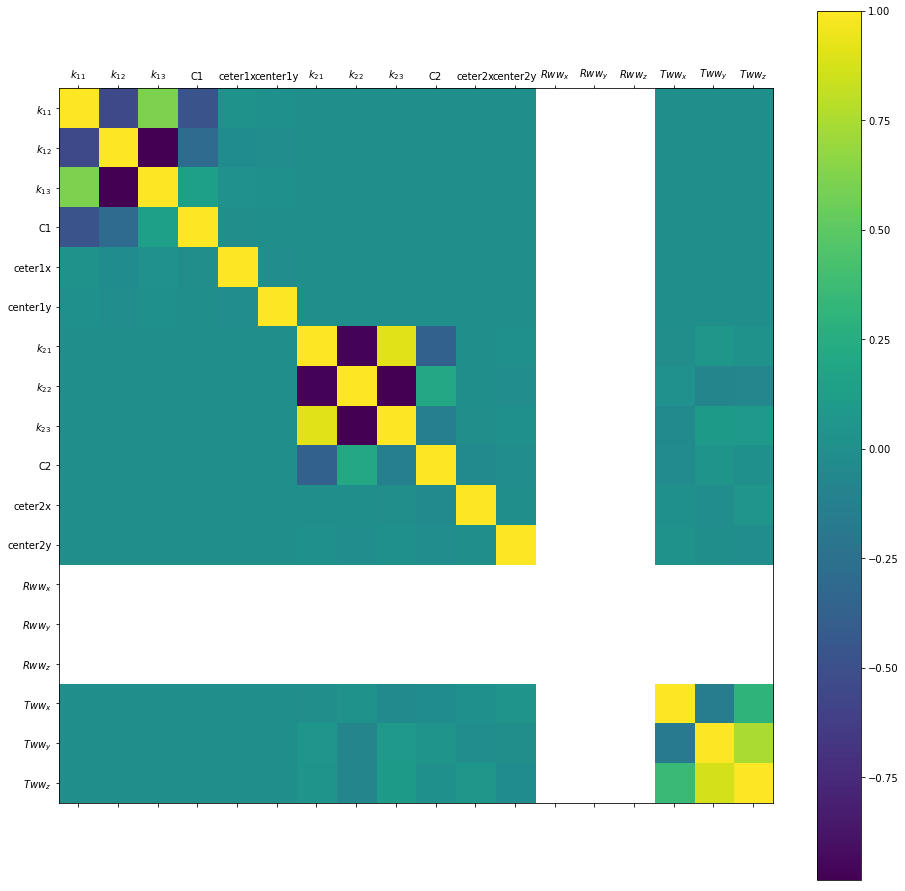

In [40]:
%autoreload

show_correlation_matrix(jacobian, figsize=(16, 16), names=[
    '$ k_{11} $', '$  k_{12} $', '$  k_{13} $',
    'C1', 'ceter1x', 'center1y', 
    '$ k_{21} $', '$  k_{22} $', '$  k_{23} $',
    'C2', 'ceter2x', 'center2y', 
    '$ Rww_x $', '$  Rww_y $', '$ Rww_z $',
    '$ Tww_x $', '$  Tww_y $', '$ Tww_z $',
]);

In [32]:
def ls_func2(params, Xs_worlds, Xs_distorteds):
    """
    Function used for least-square optimisation
    """

    ks = params[0:3]
    C = params[3]
    center = params[4:6]

    s = []
    i = 6
    for Xs_world, Xs_distorted in zip(Xs_worlds, Xs_distorteds):
        T = params[i:i+3]
        R = params[i+3:i+6]

        rotation = get_rotation(R)
        translation = np.matrix(T).T
        for X_w, X_d in zip(Xs_world, Xs_distorted):
            X_c = get_x_camera_pre(translation, rotation, X_w)
            X_pixel = get_pixel_coordinates_xc(X_c, ks, C, center)
            s.append(X_pixel[0, 0] - X_d[0])
            s.append(X_pixel[1, 0] - X_d[1])
        i += 6
    return np.array(s)


x0 = [0.0, 0, 0] + [800] + [1400, 1400]
for _ in range(len(X_cs1)):
    x0 += [1,1,5] + [0.1,0.1,0.1]
res = least_squares(ls_func2, np.array(x0), args=(X_ws1, X_cs1), jac_sparsity=None, tr_solver='lsmr', x_scale='jac', max_nfev=50)
print(res.x)

[-4.02588614e-02  3.47990257e-01 -8.17214347e-01  8.01902239e+02
  1.40001108e+03  1.40000591e+03 -1.12691247e+00 -4.06855048e-05
  3.84260476e+00 -1.34880435e-05 -2.85808957e-01  1.57079294e+00
 -5.11203708e-01  1.00423474e+00  3.84264173e+00 -2.56115565e-01
 -1.28220339e-01  4.54260361e-01  6.63095263e-01  9.11039431e-01
  3.84264330e+00 -2.33222269e-01  1.66684469e-01 -6.09635390e-01
  1.11269801e+00 -1.77772242e-01  3.84263799e+00  4.63502866e-02
  2.82100842e-01 -1.73578505e+00  3.46278819e-01 -1.07234545e+00
  3.84261807e+00 -2.86892498e+00 -3.22831264e+00  3.00487473e-01
 -7.98615388e-01 -7.95081133e-01  3.84260037e+00  2.04415379e-01
 -2.01169867e-01  2.37468460e+00]


In [5]:
print(x0)
print()

[0.0, 0.0, 0.0, 800, 1400, 1400, 0.0, 0.0, 0.0, 800, 1400, 1400, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 5, 0.1, 0.1, 0.1, 1, 1, 5, 3.141592653589793, 0.1, 0.1, 1, 1, 5, 0.1, 0.1, 0.1, 1, 1, 5, 3.141592653589793, 0.1, 0.1, 1, 1, 5, 0.1, 0.1, 0.1, 1, 1, 5, 3.141592653589793, 0.1, 0.1, 1, 1, 5, 0.1, 0.1, 0.1, 1, 1, 5, 3.141592653589793, 0.1, 0.1, 1, 1, 5, 0.1, 0.1, 0.1, 1, 1, 5, 3.141592653589793, 0.1, 0.1, 1, 1, 5, 0.1, 0.1, 0.1, 1, 1, 5, 3.141592653589793, 0.1, 0.1]

